# Sclable Machine Learning Models using Apache Spark to Predict Wind Speed and Direction from JFK Weather Data 
Author: Keshab R Sapkota

## Abstract
This project explores real world weather data from John F. Kennedy (JFK) international Airport. In this project, I build sclable maching learning models using pyspark to predict wind speed and direction at JFK International Airport. The provided JFK weather data is not clean, therefore, data cleaning step is carried out  followed by feature engineering and pipeline construction to adequately use the data. The cleaned data is splitted in 80% and 20% for training and testing purpose. Here, I build regression models to predict wind speed. Starting from Linear Regression model as a baseline, I explored Gradient Boosted Tree Regressor and Random Forrest Regressor models to imporve the prediction. The models performances are then evalueated by root mean square (RMSE) error and R<sup>2</sup> score. Next, I constructed Classification models to predict wind direction. As a classification labels, the HOURLYWindDirection column of JFK weather data is discritized into four labels using Bucketizer function, each label corresponding to North, East, South, or West direction. To predict wind direction, I built Logistic Regression Classifier as a baseline and Random Forest Classifier to improve the prediction accuracy. The classification models performance are evaluated by accuracy scores and confusion matrices are plotted to demosntrate the predicted labels over true labels. 

I completed this project as a requirement of “Apache Spark for Scalable Machine Learning on BigData” course offered by IBM.
This dataset can be found on DAX, the IBM Data Asset Exchange and can be downloaded for free.  
https://developer.ibm.com/exchanges/data/all/jfk-weather-data/

1. [Load Data](#1)

## Contents
<ol>
    <li><a href = #1>Load Data </a></li>
    <li><a href = #2>Data Cleaning </a></li>
    <ol>
        <li><a href = #2a>Check for null values</a></li>
        <li><a href = #2b>Check for special characters</a></li>
        <li><a href = #2c>Filter</a></li>
    </ol>
    <li><a href = #3>Exploring Data</a></li>
    <ol>
        <li><a href = #3a>Plot HOURLYWindSpeed</a></li>
        <li><a href = #3a>Plot HOURLYWindDirection</a></li>
        <li><a href = #3a>Correlation Matrix</a></li>
    </ol>
    <li><a href = #4>Regression problem: Hourly Wind Speed Prediction</a></li>
    <ol>
        <li><a href = #4a>Feature Engineering Pipeline</a></li>
        <li><a href = #4b>Regression Metrics</a></li>
        <li><a href = #4c>Linear Regression</a></li>
        <li><a href = #4d>Gradient Boosted Regressor</a></li>
        <li><a href = #4e>Random Forrest Regressor</a></li>
    </ol>
    <li><a href = #5>Classification Problem: Hourly Wind Direction Prediction</a></li>
    <ol>
        <li><a href = #5a>Discritization of data</a></li>
        <li><a href = #5b>Classification metrics</a></li>
        <li><a href = #5c>Confusion matrix</a></li>
        <li><a href = #5d>Logistic Regression</a></li>
        <li><a href = #5e>Random Forest Classifier</a></li>
    </ol>


## 1. Load Data <a class="anchor" id = '1'></a>
This porject is done in IBM Watson Studio. Some of the following codes to import data are specific to IBM Watson Studio.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200330033027-0001
KERNEL_ID = a3651220-32b1-4c56-8ee9-a8d25c1d4a32


In [2]:
# delete files from previous runs
!rm -f jfk_weather*

# download the file containing the data in CSV format
!wget http://max-training-data.s3-api.us-geo.objectstorage.softlayer.net/noaa-weather/jfk_weather.tar.gz

# extract the data
!tar xvfz jfk_weather.tar.gz
    
# create a dataframe out of it by using the first row as field names and trying to infer a schema based on contents
df = spark.read.option("header", "true").option("inferSchema","true").csv('jfk_weather.csv')

# register a corresponding query table
df.createOrReplaceTempView('df')

--2020-03-30 03:30:32--  http://max-training-data.s3-api.us-geo.objectstorage.softlayer.net/noaa-weather/jfk_weather.tar.gz
Resolving max-training-data.s3-api.us-geo.objectstorage.softlayer.net (max-training-data.s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to max-training-data.s3-api.us-geo.objectstorage.softlayer.net (max-training-data.s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2575759 (2.5M) [application/x-tar]
Saving to: 'jfk_weather.tar.gz'

100%[======================================>] 2,575,759   --.-K/s   in 0.03s   

2020-03-30 03:30:32 (71.5 MB/s) - 'jfk_weather.tar.gz' saved [2575759/2575759]

./._jfk_weather.csv
jfk_weather.csv


In [3]:
df.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DATE: string (nullable = true)
 |-- REPORTTPYE: string (nullable = true)
 |-- HOURLYSKYCONDITIONS: string (nullable = true)
 |-- HOURLYVISIBILITY: string (nullable = true)
 |-- HOURLYPRSENTWEATHERTYPE: string (nullable = true)
 |-- HOURLYDRYBULBTEMPF: string (nullable = true)
 |-- HOURLYDRYBULBTEMPC: string (nullable = true)
 |-- HOURLYWETBULBTEMPF: string (nullable = true)
 |-- HOURLYWETBULBTEMPC: string (nullable = true)
 |-- HOURLYDewPointTempF: string (nullable = true)
 |-- HOURLYDewPointTempC: string (nullable = true)
 |-- HOURLYRelativeHumidity: string (nullable = true)
 |-- HOURLYWindSpeed: string (nullable = true)
 |-- HOURLYWindDirection: string (nullable = true)
 |-- HOURLYWindGustSpeed: integer (nullable = true)
 |-- HOURLYStationPressure: string (nullable = true)

In this analysis, I would like to predict Hourly Wind Speed and Hourly Wind Direction in John F. Kennedy (JFK) International Airport. The relevelnt data columns to this analysis are:"HOURLYWindSpeed", "HOURLYWindDirection", "HOURLYStationPressure", "HOURLYPrecip", "HOURLYRelativeHumidity", "HOURLYDRYBULBTEMPC". In addition to these columns, the hours of days may also be relavent to this analysis. The hours of the days are extracted as below from DATE cloumn.

In [4]:
from pyspark.sql.functions import hour, minute, col, round
df = df.withColumn('HOUR', hour(col('DATE')))\
        .withColumn('MINUTES', minute(col('DATE')))\
        .withColumn('HOUR_decimal', round((col('HOUR') + col('MINUTES')/60), 2))

In [5]:
df.select('HOUR', 'MINUTES', 'HOUR_decimal').show(10)

+----+-------+------------+
|HOUR|MINUTES|HOUR_decimal|
+----+-------+------------+
|   0|     51|        0.85|
|   1|      0|         1.0|
|   1|     51|        1.85|
|   2|      3|        2.05|
|   2|     28|        2.47|
|   2|     51|        2.85|
|   3|     51|        3.85|
|   4|      0|         4.0|
|   4|     51|        4.85|
|   5|     49|        5.82|
+----+-------+------------+
only showing top 10 rows



## 2. Data Cleaning <a name = '2'></a>
 The columns may contain None, nan, strings, and other special characters. We need to filter these items and characters from the data before analysis. Let's first create a dataframe that contain only necessary columns.  

In [6]:
df_hourly = df.select("HOURLYWindSpeed", "HOURLYWindDirection", "HOURLYStationPressure", "HOURLYPrecip", "HOURLYRelativeHumidity", "HOURLYDRYBULBTEMPC", 'HOUR_decimal')
df_hourly.show(10)

+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|HOURLYWindSpeed|HOURLYWindDirection|HOURLYStationPressure|HOURLYPrecip|HOURLYRelativeHumidity|HOURLYDRYBULBTEMPC|HOUR_decimal|
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|              0|                000|                29.97|        0.01|                    92|               0.6|        0.85|
|              0|                000|                29.96|        null|                    92|               0.6|         1.0|
|              0|                000|                29.97|        0.02|                    96|               0.6|        1.85|
|              0|                000|                29.97|           T|                    93|               1.0|        2.05|
|              0|                000|                29.97|           T|                    93|         

**A. Check for null values:** Let's look for None and nan values in columns <a name = '2a'/>

In [7]:
#Check and Count Null and nan values in each columns

from pyspark.sql.functions import isnan, when, count, col

df_hourly.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_hourly.columns]).show()

+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|HOURLYWindSpeed|HOURLYWindDirection|HOURLYStationPressure|HOURLYPrecip|HOURLYRelativeHumidity|HOURLYDRYBULBTEMPC|HOUR_decimal|
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|           3187|               3308|                 3289|       34782|                  3148|              3140|           0|
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+



**B. Check for special characters** <a name = '2b'/>

In [8]:
#Check for special characters in the columns

from pyspark.sql.functions import col

#Check if columns contain special characters such as $, %, #, @
for column in df_hourly.columns:
    char_count = df_hourly.filter(col(column).rlike('[*$#@&]'))
    #For individual char or string use: df_hourly.filter(col(column).contains('string')).count()
    if char_count.count() > 0:
        print(column, ' contains special chracters')
        char_count.show()
        

HOURLYRelativeHumidity  contains special chracters
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|HOURLYWindSpeed|HOURLYWindDirection|HOURLYStationPressure|HOURLYPrecip|HOURLYRelativeHumidity|HOURLYDRYBULBTEMPC|HOUR_decimal|
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|             15|                240|                29.82|        0.43|                     *|                 *|       20.85|
|             13|                190|                29.79|        0.44|                     *|                 *|        6.85|
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+

HOURLYDRYBULBTEMPC  contains special chracters
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|HOUR

In [9]:
#Check the data types of these columns
df_hourly.dtypes

[('HOURLYWindSpeed', 'string'),
 ('HOURLYWindDirection', 'string'),
 ('HOURLYStationPressure', 'string'),
 ('HOURLYPrecip', 'string'),
 ('HOURLYRelativeHumidity', 'string'),
 ('HOURLYDRYBULBTEMPC', 'string'),
 ('HOUR_decimal', 'double')]

**C. Filter data:** From above observations, columns contain strings, special character '*', and null values. Moreover, the string data type of columns needs to be converted to double.<a name = '2c'/> 

In [10]:
import random
random.seed(42)

from pyspark.sql.functions import translate, col

# Below translate(col("HOURLYStationPressure"), "s,", "")) means some data has 's' in it and it is replaced (translated) with ''. Same for others
df_cleaned = df_hourly \
    .withColumn("HOURLYWindSpeed", df_hourly.HOURLYWindSpeed.cast('double')) \
    .withColumn("HOURLYWindDirection", df_hourly.HOURLYWindDirection.cast('double')) \
    .withColumn("HOURLYStationPressure", translate(col("HOURLYStationPressure"), "s,", "")) \
    .withColumn("HOURLYPrecip", translate(col("HOURLYPrecip"), "s,", "")) \
    .withColumn("HOURLYRelativeHumidity", translate(col("HOURLYRelativeHumidity"), "*", "")) \
    .withColumn("HOURLYDRYBULBTEMPC", translate(col("HOURLYDRYBULBTEMPC"), "*", "")) \


df_cleaned =   df_cleaned \
                    .withColumn("HOURLYStationPressure", df_cleaned.HOURLYStationPressure.cast('double')) \
                    .withColumn("HOURLYPrecip", df_cleaned.HOURLYPrecip.cast('double')) \
                    .withColumn("HOURLYRelativeHumidity", df_cleaned.HOURLYRelativeHumidity.cast('double')) \
                    .withColumn("HOURLYDRYBULBTEMPC", df_cleaned.HOURLYDRYBULBTEMPC.cast('double')) \


df_filtered = df_cleaned.filter ("""
    HOURLYWindSpeed <> 0 -- filters with data less or more than 0
    and HOURLYWindDirection <> 0
    and HOURLYStationPressure <> 0
    and HOURLYPrecip <> 0
    and HOURLYRelativeHumidity <> 0
    and HOURLYDRYBULBTEMPC <> 0
""")

In [11]:
df_filtered.show(10)

+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|HOURLYWindSpeed|HOURLYWindDirection|HOURLYStationPressure|HOURLYPrecip|HOURLYRelativeHumidity|HOURLYDRYBULBTEMPC|HOUR_decimal|
+---------------+-------------------+---------------------+------------+----------------------+------------------+------------+
|           14.0|              310.0|                 29.7|        0.01|                  85.0|               1.1|       23.85|
|           10.0|               80.0|                29.98|        0.02|                  77.0|               4.4|       12.85|
|           13.0|               70.0|                29.93|         0.1|                  86.0|               3.9|       13.85|
|            6.0|               70.0|                29.93|        0.07|                  89.0|               3.9|       14.85|
|           14.0|               70.0|                29.88|        0.03|                  87.0|         

In [12]:
df_filtered.count()

7607

## 3. Exploring Data <a name = '3'/>
Next, we plot the data and see how they look like.

In [13]:
#Data variables for the plot
x0 = df_filtered.select('HOURLYWindSpeed').collect()
x11 = df_filtered.select('HOURLYWindDirection').collect()
x12 = df_filtered.select('HOURLYStationPressure').collect()
x13 = df_filtered.select('HOURLYPrecip').collect()
x21 = df_filtered.select('HOURLYRelativeHumidity').collect()
x22 = df_filtered.select('HOURLYDRYBULBTEMPC').collect()
x23 = df_filtered.select('HOUR_decimal').collect()

**A. Plot HOURLYWindSpeed**<a name = '3a'/>

Text(0, 0.5, 'HOURLYWindSpeed')

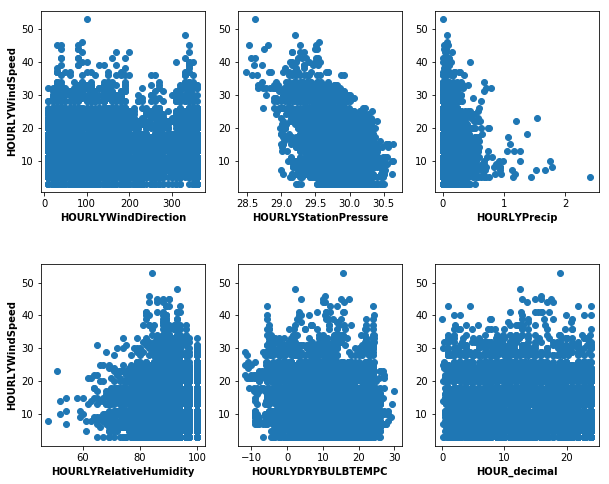

In [14]:
X = [x11, x12, x13,x21, x22, x23]
fig, axs = plt.subplots(2 ,3, figsize = (10, 8))
plt.subplots_adjust(hspace = 0.4)
a = 0
for i in range(2):
    for j in range(3):
        axs[i, j].scatter(X[a], x0)
        axs[i, j].set_xlabel(df_hourly.columns[1:][a], fontweight='bold')
        a += 1
        if a == 6:
            break
axs[0, 0].set_ylabel(df_hourly.columns[0], fontweight='bold')
axs[1, 0].set_ylabel(df_hourly.columns[0], fontweight='bold')

**B. Plot HOURLYWindDirection**<a name = '3b'/>

Text(0, 0.5, 'HOURLYWindDirection')

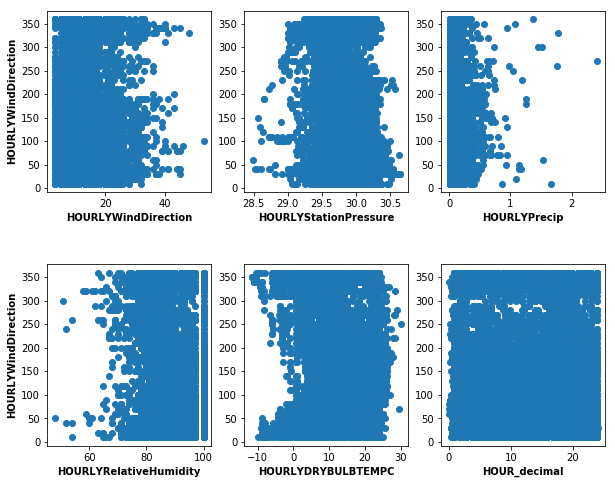

In [15]:
X = [x0, x12, x13,x21, x22, x23]
fig, axs = plt.subplots(2 ,3, figsize = (10, 8))
plt.subplots_adjust(hspace = 0.4)
a = 0
for i in range(2):
    for j in range(3):
        axs[i, j].scatter(X[a], x11)
        axs[i, j].set_xlabel(df_hourly.columns[1:][a], fontweight='bold')
        a += 1
        if a == 6:
            break
axs[0, 0].set_ylabel(df_hourly.columns[1], fontweight='bold')
axs[1, 0].set_ylabel(df_hourly.columns[1], fontweight='bold')

**C. Correlation matrix:** We want to predict the value of one column based of some others. Let's print and plot a correlation matrix. <a name = '3c'/>

In [16]:
#Construct VectorAssembler and create a pipeline
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=["HOURLYWindSpeed","HOURLYWindDirection",
                                             "HOURLYStationPressure", "HOURLYPrecip",
                                             "HOURLYRelativeHumidity","HOURLYDRYBULBTEMPC",
                                             "HOUR_decimal"],
                                  outputCol="features")
df_pipeline = vectorAssembler.transform(df_filtered)

#Calculate correlation matrix
from pyspark.ml.stat import Correlation

cor_matrix = Correlation.corr(df_pipeline,"features").head()[0].toArray()
print(cor_matrix)

[[ 1.          0.05984578 -0.41774162  0.02517726 -0.01763123 -0.13586726
   0.02095731]
 [ 0.05984578  1.         -0.16893502 -0.02643301 -0.08923836 -0.0329104
   0.01045344]
 [-0.41774162 -0.16893502  1.         -0.06842377 -0.14103083 -0.01955411
   0.00754844]
 [ 0.02517726 -0.02643301 -0.06842377  1.          0.12447344  0.2227812
   0.02999588]
 [-0.01763123 -0.08923836 -0.14103083  0.12447344  1.          0.18147625
  -0.04030813]
 [-0.13586726 -0.0329104  -0.01955411  0.2227812   0.18147625  1.
   0.06015771]
 [ 0.02095731  0.01045344  0.00754844  0.02999588 -0.04030813  0.06015771
   1.        ]]


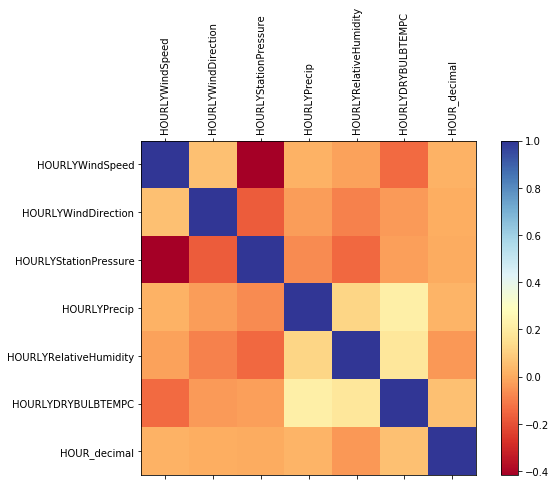

In [17]:
#Plot correlation matrix
f = plt.figure(figsize=(9, 6))
plt.matshow(cor_matrix, fignum=f.number, cmap = 'RdYlBu')
plt.colorbar()
plt.xticks(range(len(df_hourly.columns)), df_hourly.columns, rotation = 90)
plt.yticks(range(len(df_hourly.columns)), df_hourly.columns, rotation = 0)
plt.show()

## 4. Regression problem: Hourly Wind Speed Prediction <a name = '4'/>
As we can see, HOURLYWindSpeed and HOURLYWindDirection correlate with 0.06306013 whereas HOURLYWindSpeed  and HOURLYStationPressure correlate with -0.4204518. Since this is supervised learning, let’s split our data into train (80%) and test (20%) set.

In [18]:
splits = df_filtered.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]

**A. Feature Engineering Pipeline:** Let's use feature engineering and construct pipeline to prepare normalized data to train various regression models.<a name = '4a'/>

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml import Pipeline

vectorAssembler1 = VectorAssembler(inputCols=["HOURLYWindDirection",
                                             "HOURLYStationPressure", 
                                             "HOURLYPrecip",
                                             "HOURLYRelativeHumidity",
                                             "HOURLYDRYBULBTEMPC",
                                             "HOUR_decimal",
                                             ],
                                  outputCol="features")

normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

**B. Regression metrics:** Now let's define a function for evaluating our regression prediction performance. RMSE (Root Mean Squared Error) and R<sup>2</sup> values will be used here; smaller RMSE is better and larger R<sup>2</sup> is better. <a name = '4b'/>

In [20]:
def regression_metrics(prediction):
    from pyspark.ml.evaluation import RegressionEvaluator
    
    evaluator_rmse = RegressionEvaluator(labelCol="HOURLYWindSpeed", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="HOURLYWindSpeed", predictionCol="prediction", metricName="r2")
    
    rmse = evaluator_rmse.evaluate(prediction)
    r2 = evaluator_r2.evaluate(prediction)
    print("RMSE of prediction on test data = %g" % rmse)
    print("R2 of prediction on test data = %g" % r2)

### C. Linear Regression: <a name = '4c'/>
Let’s run a linear regression model first for building a baseline.

In [21]:
#Linear Regression

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="HOURLYWindSpeed", featuresCol='features_norm', maxIter=200, regParam=0.0, elasticNetParam=0.0)
pipeline = Pipeline(stages=[vectorAssembler1, normalizer,lr])

model = pipeline.fit(df_train)
prediction = model.transform(df_test)

regression_metrics(prediction)

RMSE of prediction on test data = 6.88311
R2 of prediction on test data = 0.024948


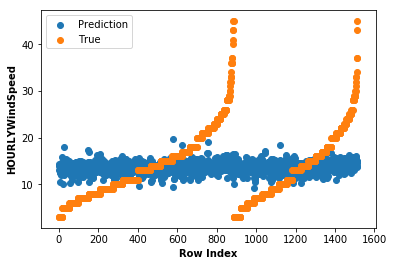

In [23]:
y_test = df_test.select('HOURLYWindSpeed').collect()
y_pred = prediction.select('prediction').collect()

plt.scatter(range(len(y_pred)), y_pred, label = 'Prediction')
plt.scatter(range(len(y_test)), y_test, label = 'True')

plt.xlabel('Row Index', fontweight = 'bold')
plt.ylabel('HOURLYWindSpeed', fontweight = 'bold')
plt.legend(loc='upper left')

### D. Gradient Boosted Tree Regressor: <a name = '4d'/>
Now we’ll try a Gradient Boosted Tree (GBT) Regressor

In [24]:
#GBT regressor
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="HOURLYWindSpeed", maxIter=150)
pipeline = Pipeline(stages=[vectorAssembler1, normalizer,gbt])

model = pipeline.fit(df_train)
prediction = model.transform(df_test)

regression_metrics(prediction)

RMSE of prediction on test data = 5.31115
R2 of prediction on test data = 0.419456


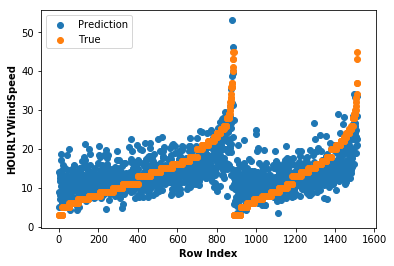

In [25]:
y_pred = prediction.select('prediction').collect()

plt.scatter(range(len(y_pred)), y_pred, label = 'Prediction')
plt.scatter(range(len(y_test)), y_test, label = 'True')

plt.xlabel('Row Index', fontweight = 'bold')
plt.ylabel('HOURLYWindSpeed', fontweight = 'bold')
plt.legend(loc='upper left')

### E. Random Forest Regressor <a name = '4e'/>
The RandomForestRegressor parameters are resonably optimized but they can be further tweaked.

In [26]:
#Random forest regressor
from pyspark.ml.regression import RandomForestRegressor

rfr = RandomForestRegressor(featuresCol = 'features', labelCol = 'HOURLYWindSpeed', numTrees = 150, maxDepth= 25, maxBins=100)
pipeline = Pipeline(stages=[vectorAssembler1, normalizer,rfr])

model = pipeline.fit(df_train)
prediction = model.transform(df_test)

regression_metrics(prediction)

RMSE of prediction on test data = 5.06706
R2 of prediction on test data = 0.471591


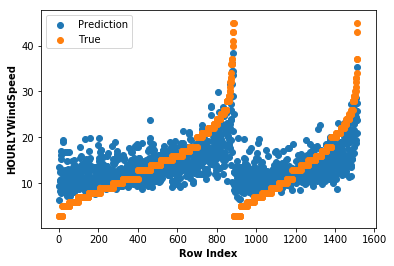

In [27]:
y_pred = prediction.select('prediction').collect()

plt.scatter(range(len(y_pred)), y_pred, label = 'Prediction')
plt.scatter(range(len(y_test)), y_test, label = 'True')

plt.xlabel('Row Index', fontweight = 'bold')
plt.ylabel('HOURLYWindSpeed', fontweight = 'bold')
plt.legend(loc='upper left')

## 5. Classification Problem: Hourly Wind Direction Prediction<a name = '5'/>

**A. Discritization of data:** In order to turn this into a classification problem we discretize the HOURLYWindDirection into four values corresponding to North, East, South, and West directions using the Bucketizer. The new feature is called HOURLYWindSpeedBucketized. <a name = '5a'/>

In [28]:
#Using bucketizer to discritize HOURLYWindDirection in to four values 

from pyspark.ml.feature import Bucketizer, OneHotEncoder

bucketizer = Bucketizer(splits=[ 0, 90, 180, 270, float('Inf') ],inputCol="HOURLYWindDirection", outputCol="HOURLYWindDirectionBucketized")
encoder = OneHotEncoder(inputCol="HOURLYWindDirectionBucketized", outputCol="HOURLYWindDirectionOHE")

**B. Classification metrics:** Lets define function to calculate accuracy of classification.<a name = '5b'/>

In [29]:
# Define function to calculate accuracy

def classification_metrics(prediction):
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    
    mcEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("HOURLYWindDirectionBucketized")
    accuracy = mcEval.evaluate(prediction)
    
    print("Accuracy of prediction on test data = %g" % accuracy)

**C. Confusion Matrix:** Let's define a function to plot confusion matrix that compares the true values and predicted values.<a name = '5c'/>

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight = 'bold')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.tight_layout()

### D. Logistic Regression <a name = '5d'/>
Let's build Logistic Regression model as a base line.

In [31]:
#Logistic Regression model

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="HOURLYWindDirectionBucketized", maxIter=10)

vectorAssembler2 = VectorAssembler(inputCols=["HOURLYWindSpeed",
                                             "HOURLYStationPressure", 
                                             "HOURLYPrecip",
                                             "HOURLYRelativeHumidity",
                                             "HOURLYDRYBULBTEMPC",
                                             "HOUR_decimal"
                                            ],
                                  outputCol="features")

pipeline = Pipeline(stages=[bucketizer,vectorAssembler2,normalizer,lr])
model = pipeline.fit(df_train)
prediction = model.transform(df_test)
classification_metrics(prediction)

Accuracy of prediction on test data = 0.410561


Confusion matrix, without normalization
[[412 143   0   4]
 [183 207   0   0]
 [152 158   0   0]
 [207  46   0   3]]


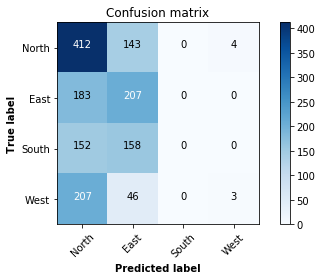

In [32]:
# Now let's plot confusion matrix

from pyspark.mllib.evaluation import MulticlassMetrics

predAndlabel = prediction.select(['prediction','HOURLYWindDirectionBucketized']).orderBy('prediction')
metrics = MulticlassMetrics(predAndlabel.rdd.map(tuple))
cnf_mat = metrics.confusionMatrix().toArray()

plt.figure()
plot_confusion_matrix(cm = cnf_mat.astype('int'), classes = ['North', 'East', 'South', 'West'])

### E. Random Forest Classifier<a name = '5e'/>

In [33]:
#Random Forest Classifier

from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol="HOURLYWindDirectionBucketized", numTrees=50, maxDepth= 25, maxBins=100)

pipeline = Pipeline(stages=[bucketizer,vectorAssembler2,normalizer,rfc])
model = pipeline.fit(df_train)
prediction = model.transform(df_test)
classification_metrics(prediction)

Accuracy of prediction on test data = 0.592739


Confusion matrix, without normalization
[[408  80  33  38]
 [103 218  55  14]
 [ 64  72 146  28]
 [ 77  23  30 126]]


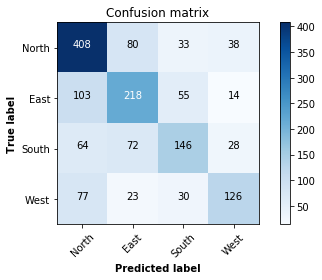

In [34]:
# Now Let's plot the confusion matrix

predAndlabel = prediction.select(['prediction','HOURLYWindDirectionBucketized']).orderBy('prediction')
metrics = MulticlassMetrics(predAndlabel.rdd.map(tuple))
cnf_mat = metrics.confusionMatrix().toArray()

plt.figure()
plot_confusion_matrix(cm = cnf_mat.astype('int'), classes = ['North', 'East', 'South', 'West'])